# Test of Data Cleaning Steps

#### The code in this Jupyter notebook is for the purpose of having a sandbox environment for me to explore the proper steps to clean the data that I collected for this project. The code is meant to be an unordered first attempt at cleaning the data into a form that's optimal for running the classification model I'm going to build before I create another Python script or Jupyter notebook that refines the code into a more streamlined format.

In [ ]:
import datetime
import requests
import pandas as pd
import geopandas as gpd
from shapely import linearrings, polygons, multipolygons
import contextily as cx

In [2]:
def get_data(resource_id):
    """
    Pull full dataset from Analyze Boston for a given resource id using api calls
    """

    # define necessary url info
    root_url = "https://data.boston.gov"
    base_api_url = "/api/3/action/datastore_search"
    limit = 1000000
    full_url = f"{root_url}{base_api_url}?resource_id={resource_id}&limit={limit}"

    # make initial request to have starting list
    r = requests.get(full_url)
    records_total = r.json()["result"]["total"]
    all_records = r.json()["result"]["records"]

    # iterate through full dataset to extend starting list until all records are pulled into the list
    while len(all_records) < records_total:
        next_url = r.json()["result"]["_links"]["next"]
        r = requests.get(root_url + next_url)
        all_records.extend(r.json()["result"]["records"])

    # convert list to dataframe and fix column order
    df = pd.DataFrame(all_records)
    return df

## Food Inspections Data Ingestion

In [3]:
df = get_data('4582bec6-2b4f-4f9e-bc55-cbaa73117f4c')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821114 entries, 0 to 821113
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   _id           821114 non-null  int64 
 1   businessname  821114 non-null  object
 2   dbaname       7914 non-null    object
 3   legalowner    539940 non-null  object
 4   namelast      821114 non-null  object
 5   namefirst     470503 non-null  object
 6   licenseno     821114 non-null  object
 7   issdttm       820793 non-null  object
 8   expdttm       821009 non-null  object
 9   licstatus     821114 non-null  object
 10  licensecat    821114 non-null  object
 11  descript      821114 non-null  object
 12  result        821114 non-null  object
 13  resultdttm    814715 non-null  object
 14  violation     763865 non-null  object
 15  viol_level    763865 non-null  object
 16  violdesc      758517 non-null  object
 17  violdttm      763862 non-null  object
 18  viol_status   763865 non

In [6]:
df

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,violdttm,viol_status,status_date,comments,address,city,state,zip,property_id,location
0,1,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,One staff person without hair restraint. Provide,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
1,2,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,Caked on food debris on can opener blade. Clea...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
2,3,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,Menu was redesigned allergy statement was remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
3,4,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-08-08 15:54:00+00,Fail,None,Several dented cans found on storage shelves. ...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
4,5,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-08-08 15:54:00+00,Fail,None,Wet wiping cloths found on counter tops . Remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821109,821110,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821110,821111,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821111,821112,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821112,821113,ZURITO,None,DELUTY EVAN,Biscay LLC,Babak Bina,574442,2024-10-08 12:22:09+00,2025-01-01 04:59:00+00,Active,...,None,None,None,None,26 CHARLES ST,BOSTON,MA,02108,158228,"(42.35674471417316, -71.06998852751329)"


In [7]:
df.iloc[0]

_id                                                            1
businessname                                  1000 Degrees Pizza
dbaname                                                     None
legalowner                                          KHOSLA VIPAN
namelast                                         Pasquriello LLC
namefirst                                   Kenneth Pasquariello
licenseno                                                 313440
issdttm                                   2017-08-14 12:49:37+00
expdttm                                   2020-01-01 04:59:00+00
licstatus                                               Inactive
licensecat                                                    FS
descript                                       Eating & Drinking
result                                                   HE_Fail
resultdttm                                2018-03-20 14:54:25+00
violation                                        13-2-304/402.11
viol_level               

In [13]:
df['status_date'].value_counts()

status_date
2013-10-29 19:39:07+00    88
2008-02-14 16:57:23+00    77
2008-01-28 20:38:39+00    77
2014-06-19 19:42:51+00    74
2008-02-22 20:08:33+00    71
                          ..
2007-05-30 19:31:30+00     1
2007-06-05 18:59:59+00     1
2007-06-05 18:57:25+00     1
2007-06-05 18:57:53+00     1
2020-11-24 16:25:43+00     1
Name: count, Length: 48874, dtype: int64

In [38]:
str.replace(df['location'][0].split(', ')[0], "(", "")

'42.359259070558295'

In [36]:
df[df['address'].isnull()]

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,violdttm,viol_status,status_date,comments,address,city,state,zip,property_id,location
1102,1103,2011 Downtown Boston Art Fridays,None,None,Al's Backwoods Berrie,Allen Chisholm,75693,2011-06-07 17:25:22+00,2012-01-01 04:59:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None
1103,1104,2011 Downtown Boston Art Fridays,None,None,Al's Backwoods Berrie,Allen Chisholm,75693,2011-06-07 17:25:22+00,2012-01-01 04:59:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None
1104,1105,2011 Downtown Boston Art Fridays,None,None,Golden Rule Honey,Laurie Herboldsheimer,75694,2011-06-07 17:24:29+00,2012-01-01 04:59:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None
1105,1106,2011 Downtown Boston Art Fridays,None,None,Golden Rule Honey,Laurie Herboldsheimer,75694,2011-06-07 17:24:29+00,2012-01-01 04:59:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None
60399,60400,Ben & Jerry's,None,None,Boston Scoop Shop Inc.,Jason Sweeney,68185,2012-05-31 13:53:58+00,2012-01-01 04:59:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700399,700400,Tall Ship Restaurant- No. 7,None,None,Tall Ship Restaurant LLC,None,454415,2021-07-08 18:06:02+00,2026-01-01 04:59:00+00,Active,...,None,None,None,None,None,,None,None,None,None
700400,700401,Tall Ship Restaurant- No. 7,None,None,Tall Ship Restaurant LLC,None,454415,2021-07-08 18:06:02+00,2026-01-01 04:59:00+00,Active,...,None,None,None,None,None,,None,None,None,None
749896,749897,Timache Claire @Dudley Station,None,None,Richmond,Peggy,73456,None,2012-10-18 12:45:45.567+00,Inactive,...,None,None,None,None,None,,None,None,None,None
796879,796880,WFNX Downtown Crossing Socials,None,None,Nantucket Nectors,c/o M. Powered Productions,68267,2011-09-12 16:44:03+00,2010-12-31 05:00:00+00,Inactive,...,None,None,None,None,None,,None,None,None,None


In [53]:
df[(df['address'].isnull() == False) & (df['location'].isnull())]

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,violdttm,viol_status,status_date,comments,address,city,state,zip,property_id,location
3783,3784,7-ELEVEN,None,None,NIDAL RAJEH,None,21001,2008-08-07 18:17:04+00,2009-01-01 04:59:00+00,Inactive,...,2008-02-14 19:54:28+00,Fail,None,Clean the following: the retail milk cooler to...,261 DARTMOUTH ST,BOSTON,Ma,02116,None,None
3784,3785,7-ELEVEN,None,None,NIDAL RAJEH,None,21001,2008-08-07 18:17:04+00,2009-01-01 04:59:00+00,Inactive,...,2008-02-14 19:54:28+00,Fail,None,Clean the floor beneath the basement soda disp...,261 DARTMOUTH ST,BOSTON,Ma,02116,None,None
3785,3786,7-ELEVEN,None,None,NIDAL RAJEH,None,21001,2008-08-07 18:17:04+00,2009-01-01 04:59:00+00,Inactive,...,2007-06-07 04:00:00+00,,None,None,261 DARTMOUTH ST,BOSTON,Ma,02116,None,None
3786,3787,7-ELEVEN,None,None,NIDAL RAJEH,None,21001,2008-08-07 18:17:04+00,2009-01-01 04:59:00+00,Inactive,...,2007-06-07 04:00:00+00,,None,None,261 DARTMOUTH ST,BOSTON,Ma,02116,None,None
3787,3788,7-ELEVEN,None,None,NIDAL RAJEH,None,21001,2008-08-07 18:17:04+00,2009-01-01 04:59:00+00,Inactive,...,2007-06-07 04:00:00+00,,None,None,261 DARTMOUTH ST,BOSTON,Ma,02116,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818250,818251,ZELMA LACEY HOUSE,None,None,MISHAWUM ASST. LIVING L L C,ATTN: DENISE,23360,2012-01-25 19:26:45+00,2022-01-01 04:59:00+00,Inactive,...,2021-07-19 14:34:57+00,Pass,2021-07-19 19:46:31+00,Mold like substance found on refrigeration rac...,9 WEST SCHOOL ST,CHARLESTOWN,Ma,02129,None,None
818251,818252,ZELMA LACEY HOUSE,None,None,MISHAWUM ASST. LIVING L L C,ATTN: DENISE,23360,2012-01-25 19:26:45+00,2022-01-01 04:59:00+00,Inactive,...,None,None,None,None,9 WEST SCHOOL ST,CHARLESTOWN,Ma,02129,None,None
818816,818817,Zen Restaurant,None,None,Ng,Raymond,28216,2009-01-14 13:50:37+00,2010-01-01 04:59:00+00,Inactive,...,None,None,None,None,21 BEACON ST,BOSTON,Ma,02108,None,None
818817,818818,Zen Restaurant,None,None,Ng,Raymond,28216,2009-01-14 13:50:37+00,2010-01-01 04:59:00+00,Inactive,...,None,None,None,None,21 BEACON ST,BOSTON,Ma,02108,None,None


In [ ]:
" ".join(df[(df['address'].isnull() == False) & (df['location'].isnull())].iloc[0]['address'].title().split())

'261 Dartmouth St'

In [84]:
df_with_address = df.copy().loc[df['address'].isnull() == False]

In [85]:
df_with_address

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,violdttm,viol_status,status_date,comments,address,city,state,zip,property_id,location
0,1,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,One staff person without hair restraint. Provide,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
1,2,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,Caked on food debris on can opener blade. Clea...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
2,3,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-03-20 14:54:25+00,Fail,None,Menu was redesigned allergy statement was remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
3,4,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-08-08 15:54:00+00,Fail,None,Several dented cans found on storage shelves. ...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
4,5,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,2018-08-08 15:54:00+00,Fail,None,Wet wiping cloths found on counter tops . Remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821109,821110,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821110,821111,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821111,821112,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)"
821112,821113,ZURITO,None,DELUTY EVAN,Biscay LLC,Babak Bina,574442,2024-10-08 12:22:09+00,2025-01-01 04:59:00+00,Active,...,None,None,None,None,26 CHARLES ST,BOSTON,MA,02108,158228,"(42.35674471417316, -71.06998852751329)"


In [102]:
df_with_address['state'].fillna('MA', inplace=True)
df_with_address['zip'].fillna('', inplace=True)

In [100]:
df_with_address['state'].info()

<class 'pandas.core.series.Series'>
Index: 820901 entries, 0 to 821113
Series name: state
Non-Null Count   Dtype 
--------------   ----- 
820901 non-null  object
dtypes: object(1)
memory usage: 12.5+ MB


In [90]:
" ".join(df_with_address.iloc[0]['address'].title().split()) + ", " + df_with_address.iloc[0]['city'].capitalize() + ", " + df_with_address.iloc[0]['state'].upper() + " " + df_with_address.iloc[0]['zip']

'55 Court St, Boston, MA 02108'

In [ ]:
df_with_address['cleaned_full_address'] = df_with_address.apply(lambda x: " ".join(x['address'].title().split()) + ", " + x['city'].title() + ", " + x['state'].upper() + " " + x['zip'], axis=1)

In [277]:
df_with_address['cleaned_full_address'][18044]

'1249 Vfw Pw, West Roxbury, MA 02132'

Other way to clean address by using as a defined function

In [ ]:
# def clean_address(dfrow):
#     return " ".join(dfrow['address'].title().split()) + ", " + dfrow['city'].capitalize() + ", " + dfrow['state'].upper() + " " + dfrow['zip']

# df_with_address['cleaned_full_address'] = df_with_address.apply(clean_address, axis=1)

In [106]:
df_with_address

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,status_date,comments,address,city,state,zip,property_id,location,cleaned_full_address,cleaned_full_address_check
0,1,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,None,One staff person without hair restraint. Provide,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108"
1,2,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,None,Caked on food debris on can opener blade. Clea...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108"
2,3,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,None,Menu was redesigned allergy statement was remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108"
3,4,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,None,Several dented cans found on storage shelves. ...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108"
4,5,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,None,Wet wiping cloths found on counter tops . Remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821109,821110,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129"
821110,821111,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129"
821111,821112,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129"
821112,821113,ZURITO,None,DELUTY EVAN,Biscay LLC,Babak Bina,574442,2024-10-08 12:22:09+00,2025-01-01 04:59:00+00,Active,...,None,None,26 CHARLES ST,BOSTON,MA,02108,158228,"(42.35674471417316, -71.06998852751329)","26 Charles St, Boston, MA 02108","26 Charles St, Boston, MA 02108"


In [278]:
df_with_address_only = df_with_address.copy().loc[df_with_address['location'].isnull()]

In [107]:
df_with_address_only = df_with_address.copy().loc[df_with_address['location'].isnull()]
df_with_coords = df_with_address.copy().loc[df_with_address['location'].isnull() == False]

In [32]:
def makeLatLong(dfrow, coordtype):
    return float(str.replace(dfrow.split(', ')[0], "(", "")) if coordtype == 'latitude' else float(str.replace(dfrow.split(', ')[1], ")", "")) if coordtype == 'longitude' else 'N/A'

In [108]:
df_with_coords['latitude'] = df_with_coords['location'].apply(lambda x: makeLatLong(x, 'latitude'))
df_with_coords['longitude'] = df_with_coords['location'].apply(lambda x: makeLatLong(x, 'longitude'))

In [109]:
df_with_coords

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,address,city,state,zip,property_id,location,cleaned_full_address,cleaned_full_address_check,latitude,longitude
0,1,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108",42.359259,-71.058901
1,2,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108",42.359259,-71.058901
2,3,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108",42.359259,-71.058901
3,4,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108",42.359259,-71.058901
4,5,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)","55 Court St, Boston, MA 02108","55 Court St, Boston, MA 02108",42.359259,-71.058901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821109,821110,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129",42.376540,-71.065421
821110,821111,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129",42.376540,-71.065421
821111,821112,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)","219 Main St, Charlestown, MA 02129","219 Main St, Charlestown, MA 02129",42.376540,-71.065421
821112,821113,ZURITO,None,DELUTY EVAN,Biscay LLC,Babak Bina,574442,2024-10-08 12:22:09+00,2025-01-01 04:59:00+00,Active,...,26 CHARLES ST,BOSTON,MA,02108,158228,"(42.35674471417316, -71.06998852751329)","26 Charles St, Boston, MA 02108","26 Charles St, Boston, MA 02108",42.356745,-71.069989


In [71]:
gdf = gpd.GeoDataFrame(df_with_coords, geometry=gpd.points_from_xy(df_with_coords['longitude'], df_with_coords['latitude']), crs="EPSG:4326")

In [72]:
gdf

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,comments,address,city,state,zip,property_id,location,latitude,longitude,geometry
0,1,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,One staff person without hair restraint. Provide,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)",42.359259,-71.058901,POINT (-71.0589 42.35926)
1,2,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,Caked on food debris on can opener blade. Clea...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)",42.359259,-71.058901,POINT (-71.0589 42.35926)
2,3,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,Menu was redesigned allergy statement was remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)",42.359259,-71.058901,POINT (-71.0589 42.35926)
3,4,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,Several dented cans found on storage shelves. ...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)",42.359259,-71.058901,POINT (-71.0589 42.35926)
4,5,1000 Degrees Pizza,None,KHOSLA VIPAN,Pasquriello LLC,Kenneth Pasquariello,313440,2017-08-14 12:49:37+00,2020-01-01 04:59:00+00,Inactive,...,Wet wiping cloths found on counter tops . Remo...,55 COURT ST,BOSTON,MA,02108,156226,"(42.359259070558295, -71.05890092520981)",42.359259,-71.058901,POINT (-71.0589 42.35926)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821109,821110,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)",42.376540,-71.065421,POINT (-71.06542 42.37654)
821110,821111,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)",42.376540,-71.065421,POINT (-71.06542 42.37654)
821111,821112,Zume's Coffee House,None,KERRIGAN ROBERT,Doherty,John,27260,2012-02-06 15:50:02+00,2025-01-01 04:59:00+00,Inactive,...,None,219 MAIN ST,CHARLESTOWN,MA,02129,88457,"(42.376539528225585, -71.06542142208765)",42.376540,-71.065421,POINT (-71.06542 42.37654)
821112,821113,ZURITO,None,DELUTY EVAN,Biscay LLC,Babak Bina,574442,2024-10-08 12:22:09+00,2025-01-01 04:59:00+00,Active,...,None,26 CHARLES ST,BOSTON,MA,02108,158228,"(42.35674471417316, -71.06998852751329)",42.356745,-71.069989,POINT (-71.06999 42.35674)


In [111]:
gdf_geocoded = gpd.tools.geocode(df_with_address_only['cleaned_full_address'], provider='nominatim', user_agent='autogis_xx', timeout=4)

KeyboardInterrupt: 

In [279]:
df_with_address_only['cleaned_full_address'].value_counts()

cleaned_full_address
300 Faneuil Hall Market Pl, Boston, MA 02109    2412
164 Harvard Av, Allston, MA 02134                627
315 Huntington Av, Boston, MA 02115              550
480 Columbus Av, Boston, MA 02118                541
49 Warren St, Roxbury, MA 02119                  467
                                                ... 
500 Washington St, Boston, MA 02109                2
225 Southampton St, Boston, MA 02118               2
185 Pilgrim Rd, Boston, MA 02215                   2
Blue Hill Av, Roxbury, MA 02119                    2
241 Perkins St, Jamaica Plain, MA 02130            1
Name: count, Length: 193, dtype: int64

In [129]:
df_with_address_only.groupby(['cleaned_full_address']).agg({'_id': lambda x: x.tolist()}).reset_index()

,cleaned_full_address,_id
0,"0 Boston Common, Boston, MA 02108","[87698, 87699, 87700, 87701, 87702, 87703, 877..."
1,"0 Boylston St, Boston, MA 02115","[176711, 176712, 176715, 176716, 176719, 17672..."
2,"0 City Hall Pl, Boston, MA","[163444, 163445]"
3,"0 City Hall Plaza, Boston, MA 02201","[163446, 163447, 163448, 163449]"
4,"0 Citywide Av, Boston, MA 00000","[575833, 575834, 575835, 575836, 575837, 57583..."
...,...,...
188,"Blue Hill Av, Roxbury, MA 02119","[270672, 270673]"
189,"Citywide, Boston, MA","[27066, 27067, 27068, 27069, 27070, 27071, 270..."
190,"Logan Airport Trmnl A, East boston, MA 02128","[268813, 268814, 268815, 268816, 268817, 26881..."
191,"Long Island, East boston, MA 02128","[130798, 130799, 130800, 130801, 130802, 13080..."


In [280]:
df_unique_addresses = df_with_address_only.groupby(['cleaned_full_address']).agg({'_id': lambda x: x.tolist()}).reset_index()

In [281]:
df_unique_addresses

,cleaned_full_address,_id
0,"0 Boston Common, Boston, MA 02108","[87698, 87699, 87700, 87701, 87702, 87703, 877..."
1,"0 Boylston St, Boston, MA 02115","[176711, 176712, 176715, 176716, 176719, 17672..."
2,"0 City Hall Pl, Boston, MA","[163444, 163445]"
3,"0 City Hall Plaza, Boston, MA 02201","[163446, 163447, 163448, 163449]"
4,"0 Citywide Av, Boston, MA 00000","[575833, 575834, 575835, 575836, 575837, 57583..."
...,...,...
188,"Blue Hill Av, Roxbury, MA 02119","[270672, 270673]"
189,"Citywide, Boston, MA","[27066, 27067, 27068, 27069, 27070, 27071, 270..."
190,"Logan Airport Trmnl A, East Boston, MA 02128","[268813, 268814, 268815, 268816, 268817, 26881..."
191,"Long Island, East Boston, MA 02128","[130798, 130799, 130800, 130801, 130802, 13080..."


In [282]:
gdf_address_geocoded = gpd.tools.geocode(df_unique_addresses['cleaned_full_address'], provider='nominatim', user_agent='autogis_xx', timeout=4)

In [283]:
gdf_address_geocoded

,geometry,address
0,POINT EMPTY,None
1,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou..."
2,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ..."
3,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ..."
4,POINT EMPTY,None
...,...,...
188,POINT (-71.07776 42.32026),"Blue Hill Avenue, Grove Hall, Roxbury, Boston,..."
189,POINT EMPTY,None
190,POINT EMPTY,None
191,POINT EMPTY,None


In [284]:
gdf_address_geocoded.loc[gdf_address_geocoded['address'].isnull()==False]

,geometry,address
1,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou..."
2,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ..."
3,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ..."
5,POINT (-71.07641 42.34999),"Copley Square, Bay Village, Back Bay, Boston, ..."
6,POINT (-71.05555 42.35298),"Dewey Square, Church Green, Downtown Boston, B..."
...,...,...
184,POINT (-71.05262 42.35731),"Broadside Tavern, 99, Broad Street, Financial ..."
185,POINT (-71.05434 42.35859),"Broad Street, Financial District, Downtown Bos..."
186,POINT (-71.08966 42.29023),"998, Blue Hill Avenue, Mattapan, Boston, Suffo..."
187,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ..."


In [148]:
gdf_address_geocoded['address'].iloc[2]

'City Hall Plaza, Dock Square, Boston, Suffolk County, Massachusetts, 02203, United States'

In [285]:
# The following join command joins the new geodataframe with the original dataframe to acquire the associated aggregated ids field
# as intended due to the fact that the order of the original dataframe is preserved in the new geodataframe after the geocoding command is run
geojoined_df = gdf_address_geocoded.join(df_unique_addresses)

In [286]:
geojoined_df

,geometry,address,cleaned_full_address,_id
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108","[87698, 87699, 87700, 87701, 87702, 87703, 877..."
1,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115","[176711, 176712, 176715, 176716, 176719, 17672..."
2,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ...","0 City Hall Pl, Boston, MA","[163444, 163445]"
3,POINT (-71.0591 42.36032),"City Hall Plaza, Dock Square, Boston, Suffolk ...","0 City Hall Plaza, Boston, MA 02201","[163446, 163447, 163448, 163449]"
4,POINT EMPTY,None,"0 Citywide Av, Boston, MA 00000","[575833, 575834, 575835, 575836, 575837, 57583..."
...,...,...,...,...
188,POINT (-71.07776 42.32026),"Blue Hill Avenue, Grove Hall, Roxbury, Boston,...","Blue Hill Av, Roxbury, MA 02119","[270672, 270673]"
189,POINT EMPTY,None,"Citywide, Boston, MA","[27066, 27067, 27068, 27069, 27070, 27071, 270..."
190,POINT EMPTY,None,"Logan Airport Trmnl A, East Boston, MA 02128","[268813, 268814, 268815, 268816, 268817, 26881..."
191,POINT EMPTY,None,"Long Island, East Boston, MA 02128","[130798, 130799, 130800, 130801, 130802, 13080..."


In [151]:
geojoined_df.explode('_id')

,geometry,address,cleaned_full_address,_id
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87698
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87699
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87700
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87701
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87702
...,...,...,...,...
192,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684837
192,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684838
192,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684839
192,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684840


In [287]:
geojoined_df_full = geojoined_df.explode('_id')

In [288]:
gdf_geocoded = geojoined_df_full.merge(df_with_address_only, on='_id')

In [289]:
gdf_geocoded

,geometry,address_x,cleaned_full_address_x,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,status_date,comments,address_y,city,state,zip,property_id,location,cleaned_full_address_y,cleaned_full_address_check
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87698,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,None,None,0 BOSTON COMMON,BOSTON,MA,02108,None,None,"0 Boston Common, Boston, MA 02108","0 Boston Common, Boston, MA 02108"
1,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87699,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,None,None,0 BOSTON COMMON,BOSTON,MA,02108,None,None,"0 Boston Common, Boston, MA 02108","0 Boston Common, Boston, MA 02108"
2,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87700,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,None,None,0 BOSTON COMMON,BOSTON,MA,02108,None,None,"0 Boston Common, Boston, MA 02108","0 Boston Common, Boston, MA 02108"
3,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87701,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,None,Repair or replace the handle to the hamburger ...,0 BOSTON COMMON,BOSTON,MA,02108,None,None,"0 Boston Common, Boston, MA 02108","0 Boston Common, Boston, MA 02108"
4,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87702,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,None,Repair the front cover to the ice machine.,0 BOSTON COMMON,BOSTON,MA,02108,None,None,"0 Boston Common, Boston, MA 02108","0 Boston Common, Boston, MA 02108"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21708,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684837,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,2010-07-22 13:19:14+00,Provide a device to allow the door to self clo...,SPECTACLE ISLAND,BOSTON,MA,00000,None,None,"Spectacle Island, Boston, MA 00000","Spectacle Island, Boston, MA 00000"
21709,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684838,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,2010-07-22 13:19:14+00,Trash area is not complete -. work in progres...,SPECTACLE ISLAND,BOSTON,MA,00000,None,None,"Spectacle Island, Boston, MA 00000","Spectacle Island, Boston, MA 00000"
21710,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684839,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,2010-07-22 13:19:14+00,No food safety certificate on site. Provide Re...,SPECTACLE ISLAND,BOSTON,MA,00000,None,None,"Spectacle Island, Boston, MA 00000","Spectacle Island, Boston, MA 00000"
21711,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684840,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,2010-07-22 13:19:14+00,No consumor advisory on menu. Provide a disclo...,SPECTACLE ISLAND,BOSTON,MA,00000,None,None,"Spectacle Island, Boston, MA 00000","Spectacle Island, Boston, MA 00000"


In [161]:
gdf_geocoded.iloc[10]

geometry                                                            POINT EMPTY
address_x                                                                  None
cleaned_full_address_x                        0 Boston Common, Boston, MA 02108
_id                                                                       87708
businessname                                       BOSTON COMMON FROG POND C.S.
dbaname                                                                    None
legalowner                                                                 None
namelast                                BOSTON COMMON FROG POND FOUNDATION INC.
namefirst                                                     THOMAS A. KERSHAW
licenseno                                                                 25308
issdttm                                                  2011-03-22 12:43:17+00
expdttm                                                  2010-12-31 05:00:00+00
licstatus                               

In [162]:
gdf_geocoded['violdttm'][10]

'2008-06-23 12:30:46+00'

In [169]:
print(datetime.datetime.strptime(gdf_geocoded['violdttm'][10], "%Y-%m-%d %H:%M:%S+%f"))

2008-06-23 12:30:46


In [170]:
def convertDateTime(dfrow):
    try:
        return datetime.datetime.strptime(dfrow, "%Y-%m-%d %H:%M:%S+%f")
    except:
        return None

In [290]:
gdf_geocoded['isstmstp'] = gdf_geocoded['issdttm'].apply(lambda x: convertDateTime(x))
gdf_geocoded['exptmstp'] = gdf_geocoded['expdttm'].apply(lambda x: convertDateTime(x))
gdf_geocoded['resulttmstp'] = gdf_geocoded['resultdttm'].apply(lambda x: convertDateTime(x))
gdf_geocoded['violtmstp'] = gdf_geocoded['violdttm'].apply(lambda x: convertDateTime(x))

In [172]:
gdf_geocoded.iloc[10]

geometry                                                            POINT EMPTY
address_x                                                                  None
cleaned_full_address_x                        0 Boston Common, Boston, MA 02108
_id                                                                       87708
businessname                                       BOSTON COMMON FROG POND C.S.
dbaname                                                                    None
legalowner                                                                 None
namelast                                BOSTON COMMON FROG POND FOUNDATION INC.
namefirst                                                     THOMAS A. KERSHAW
licenseno                                                                 25308
issdttm                                                  2011-03-22 12:43:17+00
expdttm                                                  2010-12-31 05:00:00+00
licstatus                               

In [173]:
gdf_geocoded['isstmstp'][10]-gdf_geocoded['resulttmstp'][10]

Timedelta('1005 days 20:12:43')

## Massachusetts SVI Data Ingestion

In [18]:
svi_df = pd.read_csv('MA_2020_SVI.csv')

In [19]:
svi_df

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,25,Massachusetts,MA,25001,Barnstable,25001010100,"Census Tract 101, Barnstable County, Massachus...",9.670394,2972,19,...,2.3,1.9,0.0,1.3,0.0,1.3,2.2,1.5,0.0,1.3
1,25,Massachusetts,MA,25001,Barnstable,25001010206,"Census Tract 102.06, Barnstable County, Massac...",19.784175,3662,326,...,0.6,0.8,0.0,1.1,0.0,1.1,5.9,3.5,1.0,1.1
2,25,Massachusetts,MA,25001,Barnstable,25001010208,"Census Tract 102.08, Barnstable County, Massac...",20.953316,1076,324,...,0.0,3.6,0.0,3.6,0.0,3.6,0.1,0.2,0.0,3.6
3,25,Massachusetts,MA,25001,Barnstable,25001010304,"Census Tract 103.04, Barnstable County, Massac...",7.084144,2495,242,...,5.7,4.6,0.0,1.6,0.0,1.6,0.6,0.8,0.0,1.6
4,25,Massachusetts,MA,25001,Barnstable,25001010306,"Census Tract 103.06, Barnstable County, Massac...",6.883579,2401,241,...,0.0,1.6,1.2,1.7,0.0,1.6,0.5,0.8,3.8,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,25,Massachusetts,MA,25027,Worcester,25027761100,"Census Tract 7611, Worcester County, Massachus...",27.533623,5205,29,...,2.7,3.4,0.0,0.8,0.0,0.8,0.0,0.8,0.0,0.8
1610,25,Massachusetts,MA,25027,Worcester,25027761200,"Census Tract 7612, Worcester County, Massachus...",9.061157,5578,621,...,24.8,6.1,0.1,0.2,0.0,0.7,5.2,3.8,1.0,1.1
1611,25,Massachusetts,MA,25027,Worcester,25027761300,"Census Tract 7613, Worcester County, Massachus...",3.909868,3463,440,...,6.6,3.5,0.0,1.1,0.0,1.1,4.1,2.4,0.4,0.6
1612,25,Massachusetts,MA,25027,Worcester,25027761401,"Census Tract 7614.01, Worcester County, Massac...",16.568837,4103,281,...,1.4,1.4,0.0,1.0,0.0,1.0,0.6,0.9,1.0,1.7


In [22]:
svi_df['FIPS'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1614 entries, 0 to 1613
Series name: FIPS
Non-Null Count  Dtype
--------------  -----
1614 non-null   int64
dtypes: int64(1)
memory usage: 12.7 KB


## Census Geospatial Data Ingestion

In [174]:
census_df = get_data('c7c00291-79e1-4141-aedf-10fcb060e3ce')

In [175]:
type(census_df['SHAPE'][0])

str

In [176]:
census_df['SHAPE'][0]

"{'rings': [[[-71.12623360661733, 42.24267564884669], [-71.1262066065786, 42.24463464959814], [-71.12618460570727, 42.244883649187656], [-71.12613860590643, 42.24518764967289], [-71.12606660653894, 42.24548764909733], [-71.12594560648576, 42.24586164990471], [-71.12584260628196, 42.24610164973544], [-71.1257136063365, 42.24637264964153], [-71.12554760631731, 42.24666064987332], [-71.12541060653632, 42.24687465002687], [-71.12524660548767, 42.24708664961856], [-71.12506660549963, 42.24730464949215], [-71.12484360608553, 42.24761564993765], [-71.1245116059176, 42.24797464992218], [-71.12418060613494, 42.24831164958408], [-71.12411560622026, 42.24836264989968], [-71.12354060549302, 42.24895465033092], [-71.1230396058195, 42.24947465015774], [-71.12243960487524, 42.25006665025679], [-71.12264560527461, 42.25026865073606], [-71.12269060491526, 42.250296650551554], [-71.1227016056198, 42.25030765065085], [-71.12281560585625, 42.25042965049851], [-71.12283960529307, 42.25049365028326], [-71.1

In [ ]:
census_df['SHAPE'][0]

"{'rings': [[[-71.12623360661733, 42.24267564884669], [-71.1262066065786, 42.24463464959814], [-71.12618460570727, 42.244883649187656], [-71.12613860590643, 42.24518764967289], [-71.12606660653894, 42.24548764909733], [-71.12594560648576, 42.24586164990471], [-71.12584260628196, 42.24610164973544], [-71.1257136063365, 42.24637264964153], [-71.12554760631731, 42.24666064987332], [-71.12541060653632, 42.24687465002687], [-71.12524660548767, 42.24708664961856], [-71.12506660549963, 42.24730464949215], [-71.12484360608553, 42.24761564993765], [-71.1245116059176, 42.24797464992218], [-71.12418060613494, 42.24831164958408], [-71.12411560622026, 42.24836264989968], [-71.12354060549302, 42.24895465033092], [-71.1230396058195, 42.24947465015774], [-71.12243960487524, 42.25006665025679], [-71.12264560527461, 42.25026865073606], [-71.12269060491526, 42.250296650551554], [-71.1227016056198, 42.25030765065085], [-71.12281560585625, 42.25042965049851], [-71.12283960529307, 42.25049365028326], [-71.1

In [ ]:
census_df['SHAPE'][0][11:]

"[[-71.12623360661733, 42.24267564884669], [-71.1262066065786, 42.24463464959814], [-71.12618460570727, 42.244883649187656], [-71.12613860590643, 42.24518764967289], [-71.12606660653894, 42.24548764909733], [-71.12594560648576, 42.24586164990471], [-71.12584260628196, 42.24610164973544], [-71.1257136063365, 42.24637264964153], [-71.12554760631731, 42.24666064987332], [-71.12541060653632, 42.24687465002687], [-71.12524660548767, 42.24708664961856], [-71.12506660549963, 42.24730464949215], [-71.12484360608553, 42.24761564993765], [-71.1245116059176, 42.24797464992218], [-71.12418060613494, 42.24831164958408], [-71.12411560622026, 42.24836264989968], [-71.12354060549302, 42.24895465033092], [-71.1230396058195, 42.24947465015774], [-71.12243960487524, 42.25006665025679], [-71.12264560527461, 42.25026865073606], [-71.12269060491526, 42.250296650551554], [-71.1227016056198, 42.25030765065085], [-71.12281560585625, 42.25042965049851], [-71.12283960529307, 42.25049365028326], [-71.122827604771

In [ ]:
census_df['SHAPE'][0][:-58]

"{'rings': [[[-71.12623360661733, 42.24267564884669], [-71.1262066065786, 42.24463464959814], [-71.12618460570727, 42.244883649187656], [-71.12613860590643, 42.24518764967289], [-71.12606660653894, 42.24548764909733], [-71.12594560648576, 42.24586164990471], [-71.12584260628196, 42.24610164973544], [-71.1257136063365, 42.24637264964153], [-71.12554760631731, 42.24666064987332], [-71.12541060653632, 42.24687465002687], [-71.12524660548767, 42.24708664961856], [-71.12506660549963, 42.24730464949215], [-71.12484360608553, 42.24761564993765], [-71.1245116059176, 42.24797464992218], [-71.12418060613494, 42.24831164958408], [-71.12411560622026, 42.24836264989968], [-71.12354060549302, 42.24895465033092], [-71.1230396058195, 42.24947465015774], [-71.12243960487524, 42.25006665025679], [-71.12264560527461, 42.25026865073606], [-71.12269060491526, 42.250296650551554], [-71.1227016056198, 42.25030765065085], [-71.12281560585625, 42.25042965049851], [-71.12283960529307, 42.25049365028326], [-71.1

In [ ]:
census_df['SHAPE'][0][11:-58]

'[[-71.12623360661733, 42.24267564884669], [-71.1262066065786, 42.24463464959814], [-71.12618460570727, 42.244883649187656], [-71.12613860590643, 42.24518764967289], [-71.12606660653894, 42.24548764909733], [-71.12594560648576, 42.24586164990471], [-71.12584260628196, 42.24610164973544], [-71.1257136063365, 42.24637264964153], [-71.12554760631731, 42.24666064987332], [-71.12541060653632, 42.24687465002687], [-71.12524660548767, 42.24708664961856], [-71.12506660549963, 42.24730464949215], [-71.12484360608553, 42.24761564993765], [-71.1245116059176, 42.24797464992218], [-71.12418060613494, 42.24831164958408], [-71.12411560622026, 42.24836264989968], [-71.12354060549302, 42.24895465033092], [-71.1230396058195, 42.24947465015774], [-71.12243960487524, 42.25006665025679], [-71.12264560527461, 42.25026865073606], [-71.12269060491526, 42.250296650551554], [-71.1227016056198, 42.25030765065085], [-71.12281560585625, 42.25042965049851], [-71.12283960529307, 42.25049365028326], [-71.122827604771

In [ ]:
census_df['SHAPE'][0][12:-60].split('], ')

['[-71.12623360661733, 42.24267564884669',
 '[-71.1262066065786, 42.24463464959814',
 '[-71.12618460570727, 42.244883649187656',
 '[-71.12613860590643, 42.24518764967289',
 '[-71.12606660653894, 42.24548764909733',
 '[-71.12594560648576, 42.24586164990471',
 '[-71.12584260628196, 42.24610164973544',
 '[-71.1257136063365, 42.24637264964153',
 '[-71.12554760631731, 42.24666064987332',
 '[-71.12541060653632, 42.24687465002687',
 '[-71.12524660548767, 42.24708664961856',
 '[-71.12506660549963, 42.24730464949215',
 '[-71.12484360608553, 42.24761564993765',
 '[-71.1245116059176, 42.24797464992218',
 '[-71.12418060613494, 42.24831164958408',
 '[-71.12411560622026, 42.24836264989968',
 '[-71.12354060549302, 42.24895465033092',
 '[-71.1230396058195, 42.24947465015774',
 '[-71.12243960487524, 42.25006665025679',
 '[-71.12264560527461, 42.25026865073606',
 '[-71.12269060491526, 42.250296650551554',
 '[-71.1227016056198, 42.25030765065085',
 '[-71.12281560585625, 42.25042965049851',
 '[-71.1228396

In [ ]:
testlist1

['[-71.12623360661733, 42.24267564884669]',
 '[-71.1262066065786, 42.24463464959814]',
 '[-71.12618460570727, 42.244883649187656]',
 '[-71.12613860590643, 42.24518764967289]',
 '[-71.12606660653894, 42.24548764909733]',
 '[-71.12594560648576, 42.24586164990471]',
 '[-71.12584260628196, 42.24610164973544]',
 '[-71.1257136063365, 42.24637264964153]',
 '[-71.12554760631731, 42.24666064987332]',
 '[-71.12541060653632, 42.24687465002687]',
 '[-71.12524660548767, 42.24708664961856]',
 '[-71.12506660549963, 42.24730464949215]',
 '[-71.12484360608553, 42.24761564993765]',
 '[-71.1245116059176, 42.24797464992218]',
 '[-71.12418060613494, 42.24831164958408]',
 '[-71.12411560622026, 42.24836264989968]',
 '[-71.12354060549302, 42.24895465033092]',
 '[-71.1230396058195, 42.24947465015774]',
 '[-71.12243960487524, 42.25006665025679]',
 '[-71.12264560527461, 42.25026865073606]',
 '[-71.12269060491526, 42.250296650551554]',
 '[-71.1227016056198, 42.25030765065085]',
 '[-71.12281560585625, 42.250429650

In [ ]:
testlist1 = [x+']' for x in census_df['SHAPE'][0][12:-60].split('], ')]

In [ ]:
str.replace(testlist1[0].split(', ')[0], '[', '')

'-71.12623360661733'

In [ ]:
float(str.replace(testlist1[0].split(', ')[1], ']', ''))

42.24267564884669

In [ ]:
testlist2 = [[float(str.replace(x.split(', ')[0], '[', '')), float(str.replace(x.split(', ')[1], ']', ''))] for x in testlist1]

In [ ]:
testlist2

[[-71.12623360661733, 42.24267564884669],
 [-71.1262066065786, 42.24463464959814],
 [-71.12618460570727, 42.244883649187656],
 [-71.12613860590643, 42.24518764967289],
 [-71.12606660653894, 42.24548764909733],
 [-71.12594560648576, 42.24586164990471],
 [-71.12584260628196, 42.24610164973544],
 [-71.1257136063365, 42.24637264964153],
 [-71.12554760631731, 42.24666064987332],
 [-71.12541060653632, 42.24687465002687],
 [-71.12524660548767, 42.24708664961856],
 [-71.12506660549963, 42.24730464949215],
 [-71.12484360608553, 42.24761564993765],
 [-71.1245116059176, 42.24797464992218],
 [-71.12418060613494, 42.24831164958408],
 [-71.12411560622026, 42.24836264989968],
 [-71.12354060549302, 42.24895465033092],
 [-71.1230396058195, 42.24947465015774],
 [-71.12243960487524, 42.25006665025679],
 [-71.12264560527461, 42.25026865073606],
 [-71.12269060491526, 42.250296650551554],
 [-71.1227016056198, 42.25030765065085],
 [-71.12281560585625, 42.25042965049851],
 [-71.12283960529307, 42.250493650283

In [ ]:
testpoly = polygons(testlist2)

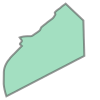

In [ ]:
testpoly

In [ ]:
testlist2

[[-71.12623360661733, 42.24267564884669],
 [-71.1262066065786, 42.24463464959814],
 [-71.12618460570727, 42.244883649187656],
 [-71.12613860590643, 42.24518764967289],
 [-71.12606660653894, 42.24548764909733],
 [-71.12594560648576, 42.24586164990471],
 [-71.12584260628196, 42.24610164973544],
 [-71.1257136063365, 42.24637264964153],
 [-71.12554760631731, 42.24666064987332],
 [-71.12541060653632, 42.24687465002687],
 [-71.12524660548767, 42.24708664961856],
 [-71.12506660549963, 42.24730464949215],
 [-71.12484360608553, 42.24761564993765],
 [-71.1245116059176, 42.24797464992218],
 [-71.12418060613494, 42.24831164958408],
 [-71.12411560622026, 42.24836264989968],
 [-71.12354060549302, 42.24895465033092],
 [-71.1230396058195, 42.24947465015774],
 [-71.12243960487524, 42.25006665025679],
 [-71.12264560527461, 42.25026865073606],
 [-71.12269060491526, 42.250296650551554],
 [-71.1227016056198, 42.25030765065085],
 [-71.12281560585625, 42.25042965049851],
 [-71.12283960529307, 42.250493650283

In [ ]:
len(testlist2)

166

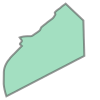

In [ ]:
testpoly

In [177]:
def makeCoords(dfrow):
    fmtstr = str.replace(dfrow, "{'rings': [", "")
    finalfmtstr = str.replace(fmtstr, "], 'spatialReference': {'latestWkid': 4326, 'wkid': 4326}}", "")
    initlist = finalfmtstr.split('], ')
    return [[float(str.replace(x.split(', ')[0], '[', '')), float(str.replace(x.split(', ')[1], ']', ''))] for x in initlist]

In [178]:
census_df['Shape Coords'] = census_df['SHAPE'].apply(lambda x: makeCoords(x))

In [179]:
census_df

,_id,geoid20,countyfp20,namelsad20,statefp20,tractce20,intptlat20,name20,funcstat20,intptlon20,mtfcc20,aland20,awater20,objectid,SHAPE,Shape Coords
0,1,25025140202,025,Census Tract,25,140202,+42.2495181,1402.02,S,-071.1175430,G5020,1538599.0,17120.0,1,"{'rings': [[[-71.12623360661733, 42.2426756488...","[[-71.12623360661733, 42.24267564884669], [-71..."
1,2,25025140300,025,Census Tract,25,140300,+42.2587734,1403,S,-071.1188131,G5020,1548879.0,38736.0,2,"{'rings': [[[-71.13011560733405, 42.2511796505...","[[-71.13011560733405, 42.25117965050007], [-71..."
2,3,25025140400,025,Census Tract,25,140400,+42.2692219,1404,S,-071.1118088,G5020,1874512.0,11680.0,3,"{'rings': [[[-71.12491460728612, 42.2727076542...","[[-71.12491460728612, 42.272707654247284], [-7..."
3,4,25025140106,025,Census Tract,25,140106,+42.2738738,1401.06,S,-071.1371416,G5020,278837.0,3116.0,4,"{'rings': [[[-71.14069361238155, 42.2747036545...","[[-71.14069361238155, 42.2747036545476], [-71...."
4,5,25025110201,025,Census Tract,25,110201,+42.2804960,1102.01,S,-071.1170508,G5020,348208.0,0.0,5,"{'rings': [[[-71.11999360559918, 42.2788276558...","[[-71.11999360559918, 42.27882765582119], [-71..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,203,25025060603,025,Census Tract,25,060603,+42.3477038,606.03,S,-071.0411470,G5020,398230.0,0.0,201,"{'rings': [[[-71.04756658623148, 42.3490676720...","[[-71.04756658623148, 42.34906767204186], [-71..."
203,204,25025070802,025,Census Tract,25,070802,+42.3417055,708.02,S,-071.0802334,G5020,129953.0,0.0,202,"{'rings': [[[-71.08315159729354, 42.3416306693...","[[-71.08315159729354, 42.34163066934546], [-71..."
204,205,25025061202,025,Census Tract,25,061202,+42.3387527,612.02,S,-071.0625085,G5020,380810.0,4897.0,203,"{'rings': [[[-71.06553059192447, 42.3360376684...","[[-71.06553059192447, 42.336037668466325], [-7..."
205,206,25025070801,025,Census Tract,25,070801,+42.3399771,708.01,S,-071.0825322,G5020,61235.0,0.0,204,"{'rings': [[[-71.08468159864695, 42.3403016688...","[[-71.08468159864695, 42.340301668816245], [-7..."


In [180]:
census_df['Polygons'] = census_df['Shape Coords'].apply(lambda x: polygons(x))

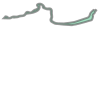

In [181]:
census_df['Polygons'][206]

In [183]:
census_df['geoid20'][206]

'25025981501'

In [182]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           207 non-null    int64 
 1   geoid20       207 non-null    object
 2   countyfp20    207 non-null    object
 3   namelsad20    207 non-null    object
 4   statefp20     207 non-null    object
 5   tractce20     207 non-null    object
 6   intptlat20    207 non-null    object
 7   name20        207 non-null    object
 8   funcstat20    207 non-null    object
 9   intptlon20    207 non-null    object
 10  mtfcc20       207 non-null    object
 11  aland20       207 non-null    object
 12  awater20      207 non-null    object
 13  objectid      207 non-null    object
 14  SHAPE         207 non-null    object
 15  Shape Coords  207 non-null    object
 16  Polygons      207 non-null    object
dtypes: int64(1), object(16)
memory usage: 27.6+ KB


In [184]:
svi_df.loc[svi_df['FIPS'] == int(census_df['geoid20'][206])]

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
1416,25,Massachusetts,MA,25025,Suffolk,25025981501,"Census Tract 9815.01, Suffolk County, Massachu...",0.346622,0,13,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [187]:
census_df['FIPS'] = census_df['geoid20'].apply(int)

In [193]:
testdf = census_df.merge(svi_df, how="inner", on='FIPS')

In [194]:
testdf

,_id,geoid20,countyfp20,namelsad20,statefp20,tractce20,intptlat20,name20,funcstat20,intptlon20,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,1,25025140202,025,Census Tract,25,140202,+42.2495181,1402.02,S,-071.1175430,...,4.7,3.1,0.0,0.6,0.0,0.6,2.2,1.7,0.3,0.6
1,2,25025140300,025,Census Tract,25,140300,+42.2587734,1403,S,-071.1188131,...,1.0,1.2,0.0,0.5,0.0,0.5,0.7,1.2,0.0,0.5
2,3,25025140400,025,Census Tract,25,140400,+42.2692219,1404,S,-071.1118088,...,0.2,0.4,0.3,0.5,0.0,0.4,3.3,2.9,0.2,0.3
3,4,25025140106,025,Census Tract,25,140106,+42.2738738,1401.06,S,-071.1371416,...,3.0,2.2,0.0,1.7,0.0,1.7,1.5,1.4,0.7,0.7
4,5,25025110201,025,Census Tract,25,110201,+42.2804960,1102.01,S,-071.1170508,...,1.9,2.0,0.0,1.5,0.0,1.5,2.2,2.0,0.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,203,25025060603,025,Census Tract,25,060603,+42.3477038,606.03,S,-071.0411470,...,5.0,4.4,0.0,3.8,0.0,3.8,0.7,1.1,0.0,3.8
203,204,25025070802,025,Census Tract,25,070802,+42.3417055,708.02,S,-071.0802334,...,5.6,4.9,0.0,1.5,0.0,1.5,0.8,1.9,0.0,1.5
204,205,25025061202,025,Census Tract,25,061202,+42.3387527,612.02,S,-071.0625085,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
205,206,25025070801,025,Census Tract,25,070801,+42.3399771,708.01,S,-071.0825322,...,15.6,11.8,0.0,3.8,0.0,3.8,1.3,2.2,0.0,3.8


In [192]:
testdf['Polygons']

0      POLYGON ((-71.12623360661733 42.24267564884669...
1      POLYGON ((-71.13011560733405 42.25117965050007...
2      POLYGON ((-71.12491460728612 42.27270765424728...
3      POLYGON ((-71.14069361238155 42.2747036545476,...
4      POLYGON ((-71.11999360559918 42.27882765582119...
                             ...                        
202    POLYGON ((-71.04756658623148 42.34906767204186...
203    POLYGON ((-71.08315159729354 42.34163066934546...
204    POLYGON ((-71.06553059192447 42.33603766846632...
205    POLYGON ((-71.08468159864695 42.34030166881624...
206    POLYGON ((-71.1686246264311 42.35896466975149,...
Name: Polygons, Length: 207, dtype: object

In [205]:
stovfw_df = gpd.GeoDataFrame(testdf, geometry=testdf['Polygons'], crs="EPSG:4326")

In [206]:
stovfw_df

,_id,geoid20,countyfp20,namelsad20,statefp20,tractce20,intptlat20,name20,funcstat20,intptlon20,...,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,geometry
0,1,25025140202,025,Census Tract,25,140202,+42.2495181,1402.02,S,-071.1175430,...,3.1,0.0,0.6,0.0,0.6,2.2,1.7,0.3,0.6,"POLYGON ((-71.12623 42.24268, -71.12621 42.244..."
1,2,25025140300,025,Census Tract,25,140300,+42.2587734,1403,S,-071.1188131,...,1.2,0.0,0.5,0.0,0.5,0.7,1.2,0.0,0.5,"POLYGON ((-71.13012 42.25118, -71.12961 42.251..."
2,3,25025140400,025,Census Tract,25,140400,+42.2692219,1404,S,-071.1118088,...,0.4,0.3,0.5,0.0,0.4,3.3,2.9,0.2,0.3,"POLYGON ((-71.12491 42.27271, -71.12445 42.273..."
3,4,25025140106,025,Census Tract,25,140106,+42.2738738,1401.06,S,-071.1371416,...,2.2,0.0,1.7,0.0,1.7,1.5,1.4,0.7,0.7,"POLYGON ((-71.14069 42.2747, -71.14065 42.2751..."
4,5,25025110201,025,Census Tract,25,110201,+42.2804960,1102.01,S,-071.1170508,...,2.0,0.0,1.5,0.0,1.5,2.2,2.0,0.0,1.5,"POLYGON ((-71.11999 42.27883, -71.11984 42.279..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,203,25025060603,025,Census Tract,25,060603,+42.3477038,606.03,S,-071.0411470,...,4.4,0.0,3.8,0.0,3.8,0.7,1.1,0.0,3.8,"POLYGON ((-71.04757 42.34907, -71.04721 42.349..."
203,204,25025070802,025,Census Tract,25,070802,+42.3417055,708.02,S,-071.0802334,...,4.9,0.0,1.5,0.0,1.5,0.8,1.9,0.0,1.5,"POLYGON ((-71.08315 42.34163, -71.08303 42.341..."
204,205,25025061202,025,Census Tract,25,061202,+42.3387527,612.02,S,-071.0625085,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,"POLYGON ((-71.06553 42.33604, -71.06551 42.336..."
205,206,25025070801,025,Census Tract,25,070801,+42.3399771,708.01,S,-071.0825322,...,11.8,0.0,3.8,0.0,3.8,1.3,2.2,0.0,3.8,"POLYGON ((-71.08468 42.3403, -71.08431 42.3406..."


In [203]:
type(stovfw_df)

geopandas.geodataframe.GeoDataFrame

In [291]:
testgeodf = gdf_geocoded.sjoin(stovfw_df, how="left", predicate="intersects")

In [292]:
testgeodf

,geometry,address_x,cleaned_full_address_x,_id_left,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87698,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87699,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87700,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87701,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87702,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21708,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684837,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21709,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684838,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21710,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684839,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21711,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684840,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
testgeodf.loc[testgeodf['address_x'].isnull() == False]

,geometry,address_x,cleaned_full_address_x,_id_left,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
134,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176711,Copley Sq Farmers Market,None,None,Signal Rock Farm,Marianne & Kevin McCarthy,28287,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
135,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176712,Copley Sq Farmers Market,None,None,Signal Rock Farm,Marianne & Kevin McCarthy,28287,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
136,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176715,Copley Sq. Farmers Market,None,None,Breadsong Bakery,Martha Sweet,26562,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
137,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176716,Copley Sq. Farmers Market,None,None,Breadsong Bakery,Martha Sweet,26562,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
138,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176719,Copley Sq. Farmers Market,None,None,Butter Brook Farm,Guy McKay,26792,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21307,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637129,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21308,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637130,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21309,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637131,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21310,POINT (-71.07776 42.32026),"Blue Hill Avenue, Grove Hall, Roxbury, Boston,...","Blue Hill Av, Roxbury, MA 02119",270672,Farmers Market Dudley Town Commons,None,None,The Food Project,Robert Burns,27336,...,0.4,0.6,0.0,0.9,0.0,0.9,2.8,2.1,1.5,1.3


<Axes: >

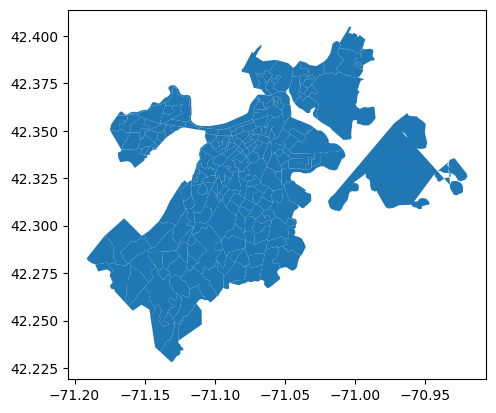

In [213]:
stovfw_df.plot()

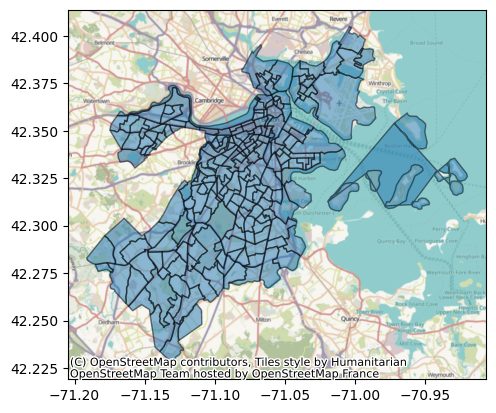

In [ ]:
cx.add_basemap(stovfw_df.plot(alpha=0.5, edgecolor="k"), crs="EPSG:4326")

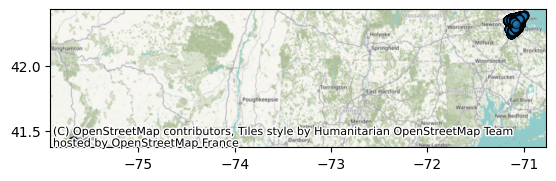

In [ ]:
cx.add_basemap(testgeodf.plot(alpha=0.5, edgecolor="k"), crs="EPSG:4326")

In [237]:
testgeodf

,geometry,address_x,cleaned_full_address_x,_id_left,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
0,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87698,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87699,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87700,Boston Common Frog Pond Concession Stand,None,None,KERSHAW,THOMAS A,25895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87701,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT EMPTY,None,"0 Boston Common, Boston, MA 02108",87702,BOSTON COMMON FROG POND C.S.,None,None,BOSTON COMMON FROG POND FOUNDATION INC.,THOMAS A. KERSHAW,25308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21708,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684837,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21709,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684838,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21710,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684839,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21711,POINT EMPTY,None,"Spectacle Island, Boston, MA 00000",684840,Summer Shack,None,None,Summer Shack,Jasper White,33362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [261]:
print(testgeodf['geometry'][134].x)

-71.08651150014033


In [294]:
testgeodf.loc[testgeodf['address_x'].isnull() == False]

,geometry,address_x,cleaned_full_address_x,_id_left,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
134,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176711,Copley Sq Farmers Market,None,None,Signal Rock Farm,Marianne & Kevin McCarthy,28287,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
135,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176712,Copley Sq Farmers Market,None,None,Signal Rock Farm,Marianne & Kevin McCarthy,28287,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
136,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176715,Copley Sq. Farmers Market,None,None,Breadsong Bakery,Martha Sweet,26562,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
137,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176716,Copley Sq. Farmers Market,None,None,Breadsong Bakery,Martha Sweet,26562,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
138,POINT (-71.08651 42.34759),"Boylston Street, Back Bay, Boston, Suffolk Cou...","0 Boylston St, Boston, MA 02115",176719,Copley Sq. Farmers Market,None,None,Butter Brook Farm,Guy McKay,26792,...,12.5,4.0,0.0,1.1,0.0,1.1,3.2,2.0,0.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21307,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637129,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21308,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637130,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21309,POINT (-71.10088 42.34024),"Avenue Louis Pasteur, Fenway-Kenmore, Boston, ...","Ave Louis Pasteur, Boston, MA 02115",637131,Simmons College-Meyers Cafe,None,None,Services LLC,Aramark Educational,26859,...,12.9,3.8,0.0,0.7,0.0,0.7,2.8,1.0,0.5,0.8
21310,POINT (-71.07776 42.32026),"Blue Hill Avenue, Grove Hall, Roxbury, Boston,...","Blue Hill Av, Roxbury, MA 02119",270672,Farmers Market Dudley Town Commons,None,None,The Food Project,Robert Burns,27336,...,0.4,0.6,0.0,0.9,0.0,0.9,2.8,2.1,1.5,1.3


In [311]:
testgeodf['address_x'].loc[testgeodf['geometry'].y < 42]

18044    630, North Hyde Park Avenue, West Side, Hyde P...
18045    630, North Hyde Park Avenue, West Side, Hyde P...
18046    630, North Hyde Park Avenue, West Side, Hyde P...
18047    630, North Hyde Park Avenue, West Side, Hyde P...
Name: address_x, dtype: object

In [297]:
testgeodf['cleaned_full_address_x'].value_counts()

cleaned_full_address_x
300 Faneuil Hall Market Pl, Boston, MA 02109    2412
164 Harvard Av, Allston, MA 02134                627
315 Huntington Av, Boston, MA 02115              550
480 Columbus Av, Boston, MA 02118                541
49 Warren St, Roxbury, MA 02119                  467
                                                ... 
Blue Hill Av, Roxbury, MA 02119                    2
185 Pilgrim Rd, Boston, MA 02215                   2
0 City Hall Pl, Boston, MA                         2
500 Washington St, Boston, MA 02109                2
241 Perkins St, Jamaica Plain, MA 02130            1
Name: count, Length: 193, dtype: int64

In [309]:
testgeodf.loc[testgeodf.index.isin([18044,18045,18046,18047])]

,geometry,address_x,cleaned_full_address_x,_id_left,businessname,dbaname,legalowner,namelast,namefirst,licenseno,...,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE
18044,POINT (-75.6757 41.41909),"630, North Hyde Park Avenue, West Side, Hyde P...","630 Hyde Park Ave., Hyde Park, MA 02131",435796,Marabou Restaurant,None,None,Dieudonne,Claude,25694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18045,POINT (-75.6757 41.41909),"630, North Hyde Park Avenue, West Side, Hyde P...","630 Hyde Park Ave., Hyde Park, MA 02131",435797,Marabou Restaurant,None,None,Dieudonne,Claude,25694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18046,POINT (-75.6757 41.41909),"630, North Hyde Park Avenue, West Side, Hyde P...","630 Hyde Park Ave., Hyde Park, MA 02131",435798,Marabou Restaurant,None,None,Dieudonne,Claude,25694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18047,POINT (-75.6757 41.41909),"630, North Hyde Park Avenue, West Side, Hyde P...","630 Hyde Park Ave., Hyde Park, MA 02131",435799,Marabou Restaurant,None,None,Dieudonne,Claude,25694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [308]:
testgeodf.index.isin([18044,18045,18046,18047])

array([False, False, False, ..., False, False, False], shape=(21713,))

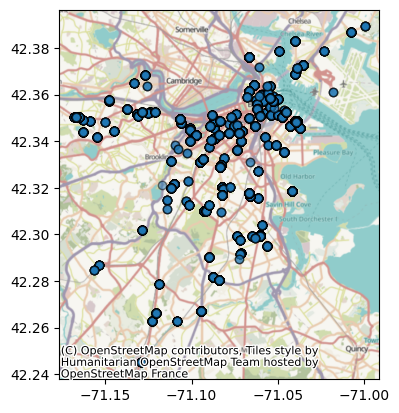

In [313]:
cx.add_basemap(testgeodf.loc[testgeodf['geometry'].y > 42].plot(alpha=0.5, edgecolor="k"), crs="EPSG:4326")

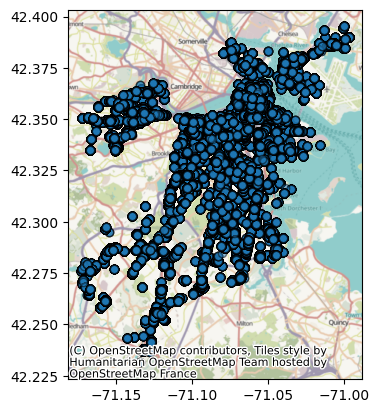

In [316]:
cx.add_basemap(gdf.loc[gdf['geometry'].y > 42].plot(alpha=0.5, edgecolor="k"), crs="EPSG:4326")

In [317]:
gdf.loc[gdf['geometry'].y < 42]

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,comments,address,city,state,zip,property_id,location,latitude,longitude,geometry
527,528,129 Lake Street Cafe,None,None,Trustees of Boston College,None,74211,2013-10-24 12:48:40+00,2026-01-01 04:59:00+00,Active,...,Interior/exterior of ice machine soiled.Clean ...,127 LAKE ST,BRIGHTON/,MA,02135,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
528,529,129 Lake Street Cafe,None,None,Trustees of Boston College,None,74211,2013-10-24 12:48:40+00,2026-01-01 04:59:00+00,Active,...,Handwash sink obstructed with stacked dish rac...,127 LAKE ST,BRIGHTON/,MA,02135,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
529,530,129 Lake Street Cafe,None,None,Trustees of Boston College,None,74211,2013-10-24 12:48:40+00,2026-01-01 04:59:00+00,Active,...,"Provide ""Please use utensil signage"" at all se...",127 LAKE ST,BRIGHTON/,MA,02135,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
530,531,129 Lake Street Cafe,None,None,Trustees of Boston College,None,74211,2013-10-24 12:48:40+00,2026-01-01 04:59:00+00,Active,...,Clean to remove evidence of rodent droppings i...,127 LAKE ST,BRIGHTON/,MA,02135,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
531,532,129 Lake Street Cafe,None,None,Trustees of Boston College,None,74211,2013-10-24 12:48:40+00,2026-01-01 04:59:00+00,Active,...,Clean under and around all hot line equipment ...,127 LAKE ST,BRIGHTON/,MA,02135,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820966,820967,Zumas Tex-Mex Grill,None,None,B B Kitchen Inc.,Cody Baker,26357,2012-02-22 15:46:22+00,2021-01-01 04:59:00+00,Inactive,...,Waste water from leaking pipe pooling on floor...,100-199 FANEUIL HALL MARKET PL,BOSTON,MA,02109,None,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820967,820968,Zumas Tex-Mex Grill,None,None,B B Kitchen Inc.,Cody Baker,26357,2012-02-22 15:46:22+00,2021-01-01 04:59:00+00,Inactive,...,Leaking waste pipe in wall behind cookline per...,100-199 FANEUIL HALL MARKET PL,BOSTON,MA,02109,None,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820968,820969,Zumas Tex-Mex Grill,None,None,B B Kitchen Inc.,Cody Baker,26357,2012-02-22 15:46:22+00,2021-01-01 04:59:00+00,Inactive,...,Leaking waste drain behind cookline per disuss...,100-199 FANEUIL HALL MARKET PL,BOSTON,MA,02109,None,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820969,820970,Zumas Tex-Mex Grill,None,None,B B Kitchen Inc.,Cody Baker,26357,2012-02-22 15:46:22+00,2021-01-01 04:59:00+00,Inactive,...,Waste water from leaking pipe pooling on floor...,100-199 FANEUIL HALL MARKET PL,BOSTON,MA,02109,None,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)


In [318]:
gdf['address'].loc[gdf['geometry'].y < 42].value_counts()

address
1   CITYWIDE ST                     6723
200   FANEUIL HALL MARKET PL        2909
800   BOYLSTON ST                   2817
100-199   FANEUIL HALL MARKET PL    2758
100   LEGENDS WA                    2416
                                    ... 
218   BOWDOIN                          1
631   V F W  PK                        1
121   CHARLES STREET SOUTH             1
645   V F W  PK                        1
33   BATTERYMARCH                      1
Name: count, Length: 318, dtype: int64

In [319]:
gdf.loc[gdf['address']=='1   CITYWIDE ST']

,_id,businessname,dbaname,legalowner,namelast,namefirst,licenseno,issdttm,expdttm,licstatus,...,comments,address,city,state,zip,property_id,location,latitude,longitude,geometry
7195,7196,Across The Border,None,None,Salazar,Douglas,369756,2018-08-20 13:01:18+00,2025-01-01 04:59:00+00,Active,...,No hair restraints. Provide.,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
7196,7197,Across The Border,None,None,Salazar,Douglas,369756,2018-08-20 13:01:18+00,2025-01-01 04:59:00+00,Active,...,Door open with no screen. Maintain closed or p...,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
7197,7198,Across The Border,None,None,Salazar,Douglas,369756,2018-08-20 13:01:18+00,2025-01-01 04:59:00+00,Active,...,None,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
7198,7199,Across The Border,None,None,Salazar,Douglas,369756,2018-08-20 13:01:18+00,2025-01-01 04:59:00+00,Active,...,None,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
7199,7200,Across The Border,None,None,Salazar,Douglas,369756,2018-08-20 13:01:18+00,2025-01-01 04:59:00+00,Active,...,None,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820129,820130,Zo Truck,None,None,Zo Truck Inc.,None,120456,2014-02-27 17:05:27+00,2021-01-01 04:59:00+00,Inactive,...,3 bay sink/remove white board from sink and ho...,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820130,820131,Zo Truck,None,None,Zo Truck Inc.,None,120456,2014-02-27 17:05:27+00,2021-01-01 04:59:00+00,Inactive,...,Handwash sink blocked- Visibly dry- Employees ...,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820131,820132,Zo Truck,None,None,Zo Truck Inc.,None,120456,2014-02-27 17:05:27+00,2021-01-01 04:59:00+00,Inactive,...,0ppm chlorine in sanitizer used for wiping cloths,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)
820132,820133,Zo Truck,None,None,Zo Truck Inc.,None,120456,2014-02-27 17:05:27+00,2021-01-01 04:59:00+00,Inactive,...,Foods in lift top refrigeration a 46F,1 CITYWIDE ST,BOSTON,MA,02128,0,"(34.244386753001244, -73.6513909034731)",34.244387,-73.651391,POINT (-73.65139 34.24439)


Agenda:
- Geocode the food inspections with incorrect point coordinates
- Determine essential fields to keep for prediction model and analysis
- Cleaning unstructured text data in df for NLP Analysis